In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel, SliceRepModel, SliceCatModel, SliceEnsembleModel
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


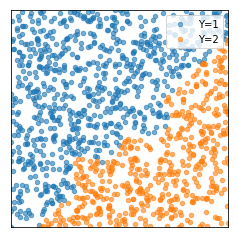

Vizualizing labelset:slice_1:pred from payload_test


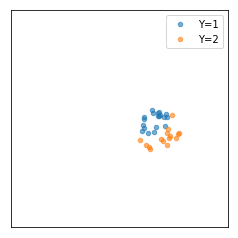

Vizualizing labelset:slice_1:ind from payload_test


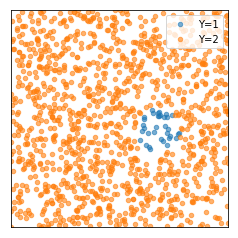

Vizualizing labelset:slice_2:pred from payload_test


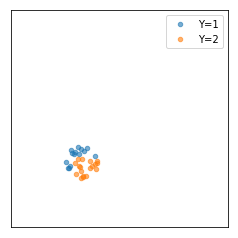

Vizualizing labelset:slice_2:ind from payload_test


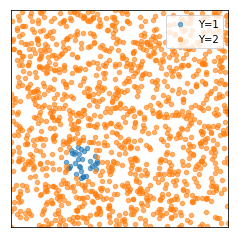

Vizualizing labelset:remainder:pred from payload_test


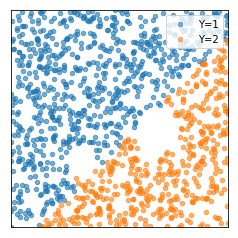

Vizualizing labelset:remainder:ind from payload_test


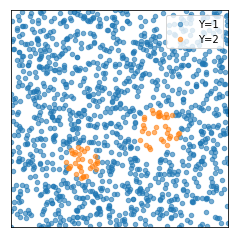

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))
h_dim = 2

model_configs = {
#     'soft_ens_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceEnsembleModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'custom_neck_dim': 2*len(all_slice_funcs)
#     }, 
#     'soft_cat_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'create_preds': False,
#         'model_class': SliceCatModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'h_dim': h_dim,
#         'custom_neck_dim': (h_dim+1)*len(all_slice_funcs)
#     },   
#     'soft_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         }
#     },   
    'soft_param_rep': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'create_preds': False,
        'model_class': SliceRepModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        },
        'h_dim': h_dim
    },
    'hard_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'model_class': MetalModel,
        'slice_weights': {'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier}
    },
    'manual_reweighting': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'slice_weights': {"slice_1": 50}, # 10x weight of slice_2, everythign else default
        'model_class': MetalModel        
    },
    'moe': {
        'slice_funcs': {},
        'create_ind': False,
        'model_class': MoEModel
    },
    'naive': {
        'slice_funcs': {},
        'model_class': MetalModel   
    }
}

In [11]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 300,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": True,
    "progress_bar": False
}

==========Initializing + Training soft_param_rep==========
Creating 4 tasks...
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:ind': 'test_task:slice_2:ind', 'labelset:BASE:ind': 'test_task:BASE:ind'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:ind': 'test_task:slice_2:ind', 'labelset:BASE:ind': 'test_task:BASE:ind'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task', 'lab

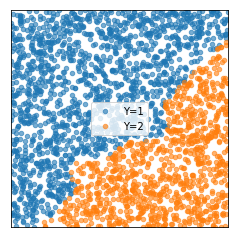

Vizualizing labelset:slice_1:ind from payload_train


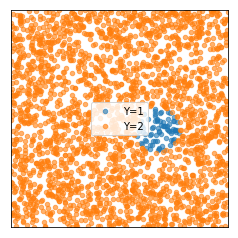

Vizualizing labelset:slice_2:ind from payload_train


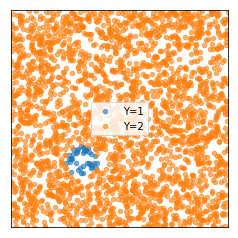

Vizualizing labelset:BASE:ind from payload_train


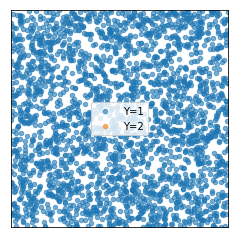

No cuda device available. Using cpu instead.

Network architecture:
SliceRepModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): M

[35.0 epo]: test_task:[payload_train/labelset_gold/loss=5.74e-02, payload_valid/labelset_gold/accuracy=9.78e-01, payload_valid/labelset_gold/f1=9.81e-01, payload_valid/labelset_gold/acc_f1=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.88e-01, payload_valid/labelset:slice_1:ind/f1=8.10e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.99e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.04e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_valid/labelset:BASE:ind/f1=1.00e+00, payload_valid/labelset:BASE:ind/acc_f1=1.00e+00] model:[train/all/loss=1.83e-02, train/all/lr=1.00e-02, valid/all/loss=2.13e-02]
[40.0 epo]: test_task:[payload_train/labelset_gold/loss

[80.0 epo]: test_task:[payload_train/labelset_gold/loss=3.66e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.46e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.50e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.20e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.37e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.03e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_valid/labelset:BASE:ind/f1=1.00e+00, payload_valid/labelset:BASE:ind/acc_f1=1.00e+00] model:[train/all/loss=1.22e-02, train/all/lr=1.00e-02, valid/all/loss=1.54e-02]
[85.0 epo]: test_task:[payload_train/labelset_gold/loss

[125.0 epo]: test_task:[payload_train/labelset_gold/loss=3.47e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.61e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.26e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.48e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.49e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_valid/labelset:BASE:ind/f1=1.00e+00, payload_valid/labelset:BASE:ind/acc_f1=1.00e+00] model:[train/all/loss=1.14e-02, train/all/lr=1.00e-02, valid/all/loss=1.44e-02]
[130.0 epo]: test_task:[payload_train/labelset_gold/lo

[170.0 epo]: test_task:[payload_train/labelset_gold/loss=3.28e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.61e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.26e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.63e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_valid/labelset:BASE:ind/f1=1.00e+00, payload_valid/labelset:BASE:ind/acc_f1=1.00e+00] model:[train/all/loss=1.07e-02, train/all/lr=1.00e-02, valid/all/loss=1.35e-02]
[175.0 epo]: test_task:[payload_train/labelset_gold/lo

[215.0 epo]: test_task:[payload_train/labelset_gold/loss=3.09e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.52e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.61e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.26e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.67e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=6.90e-02, payload_valid/labelset:slice_2:ind/acc_f1=5.24e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.06e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_valid/labelset:BASE:ind/f1=1.00e+00, payload_valid/labelset:BASE:ind/acc_f1=1.00e+00] model:[train/all/loss=1.01e-02, train/all/lr=1.00e-02, valid/all/loss=1.27e-02]
[220.0 epo]: test_task:[payload_train/labelset_gold/lo

[260.0 epo]: test_task:[payload_train/labelset_gold/loss=2.84e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.39e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.64e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.28e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=3.03e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.42e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_valid/labelset:BASE:ind/f1=1.00e+00, payload_valid/labelset:BASE:ind/acc_f1=1.00e+00] model:[train/all/loss=9.23e-03, train/all/lr=1.00e-02, valid/all/loss=1.26e-02]
[265.0 epo]: test_task:[payload_train/labelset_gold/lo

[300.01 epo]: model:[train/all/lr=1.00e-02, valid/all/loss=1.11e-02] test_task:[payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.68e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.30e-01] test_task:slice_2:ind:[payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=5.26e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.56e-01] test_task:BASE:ind:[payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_valid/labelset:BASE:ind/f1=1.00e+00, payload_valid/labelset:BASE:ind/acc_f1=1.00e+00]
Finished training


/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/acc_f1': 0.9819198448610214,
 'test_task/payload_test/labelset_gold/accuracy': 0.98,
 'test_task/payload_test/labelset_gold/f1': 0.9838396897220426,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9920447317388494,
 'test_task/payload_train/labelset_gold/accuracy': 0.9912,
 'test_task/payload_train/labelset_gold/f1': 0.9928894634776988,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/f1': 1.0,
 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/acc_f1': 0.9595384615384615,
 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.996,
 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/f1'

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


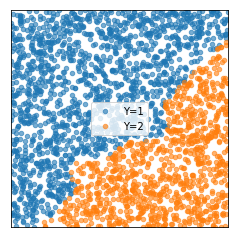

Vizualizing labelset:slice_1:pred from payload_train


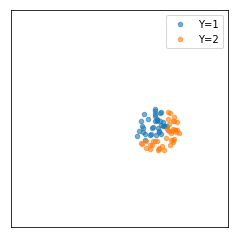

Vizualizing labelset:slice_2:pred from payload_train


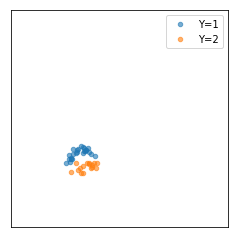

Vizualizing labelset:BASE:pred from payload_train


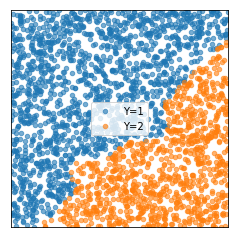

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): M

[35.0 epo]: test_task:[payload_train/labelset_gold/loss=8.57e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.57e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.34e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.80e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.48e-02, train/all/lr=1.00e-02, valid/all/loss=8.36e-02]
[40.0 epo]: test_task:[payload_train/lab

[80.0 epo]: test_task:[payload_train/labelset_gold/loss=8.54e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.54e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.33e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.13e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.45e-02, train/all/lr=1.00e-02, valid/all/loss=8.35e-02]
[85.0 epo]: test_task:[payload_train/lab

[125.0 epo]: test_task:[payload_train/labelset_gold/loss=8.53e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.53e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.33e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.09e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.44e-02, train/all/lr=1.00e-02, valid/all/loss=8.37e-02]
[130.0 epo]: test_task:[payload_train/l

[170.0 epo]: test_task:[payload_train/labelset_gold/loss=8.53e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.53e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.36e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.82e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.92e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.68e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.43e-02, train/all/lr=1.00e-02, valid/all/loss=8.38e-02]
[175.0 epo]: test_task:[payload_train/l

[215.0 epo]: test_task:[payload_train/labelset_gold/loss=8.53e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.53e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.38e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.82e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.92e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.59e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=8.43e-02, train/all/lr=1.00e-02, valid/all/loss=8.39e-02]
[220.0 epo]: test_task:[payload_train/l

[260.0 epo]: test_task:[payload_train/labelset_gold/loss=8.52e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.52e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.38e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.82e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.92e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.52e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.43e-02, train/all/lr=1.00e-02, valid/all/loss=8.40e-02]
[265.0 epo]: test_task:[payload_train/l

[300.01 epo]: model:[train/all/lr=1.00e-02, valid/all/loss=8.40e-02] test_task:[payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.82e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.92e-01] test_task:slice_2:pred:[payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] test_task:BASE:pred:[payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01]
Finished training


/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/acc_f1': 0.9673420195439739,
 'test_task/payload_test/labelset_gold/accuracy': 0.964,
 'test_task/payload_test/labelset_gold/f1': 0.970684039087948,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9720388254486133,
 'test_task/payload_train/labelset_gold/accuracy': 0.9692,
 'test_task/payload_train/labelset_gold/f1': 0.9748776508972267,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/acc_f1': 0.9673420195439739,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.964,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/f1': 0.970684039087948,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/acc_f1': 0.9720388254486133,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.9692,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/f1': 0.9748776508972267,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9174208144796381,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


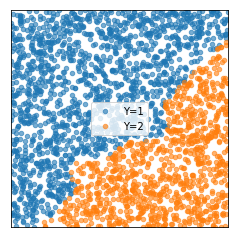

Vizualizing labelset:slice_1:pred from payload_train


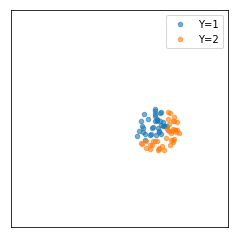

Vizualizing labelset:slice_2:pred from payload_train


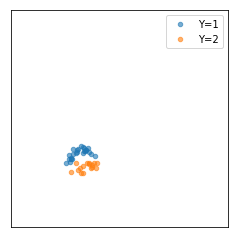

Vizualizing labelset:BASE:pred from payload_train


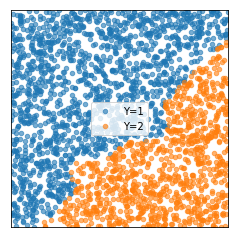

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): M

[35.0 epo]: test_task:[payload_train/labelset_gold/loss=1.01e-01, payload_valid/labelset_gold/accuracy=9.77e-01, payload_valid/labelset_gold/f1=9.80e-01, payload_valid/labelset_gold/acc_f1=9.79e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.01e-01, payload_valid/labelset:BASE:pred/accuracy=9.77e-01, payload_valid/labelset:BASE:pred/f1=9.80e-01, payload_valid/labelset:BASE:pred/acc_f1=9.79e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.25e+01, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.07e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=4.39e-01, train/all/lr=1.00e-02, valid/all/loss=2.23e-01]
[40.0 epo]: test_task:[payload_train/lab

[80.0 epo]: test_task:[payload_train/labelset_gold/loss=9.09e-02, payload_valid/labelset_gold/accuracy=9.75e-01, payload_valid/labelset_gold/f1=9.79e-01, payload_valid/labelset_gold/acc_f1=9.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.09e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01, payload_valid/labelset:BASE:pred/f1=9.79e-01, payload_valid/labelset:BASE:pred/acc_f1=9.77e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.21e+01, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.70e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.73e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.06e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=5.73e-01, train/all/lr=1.00e-02, valid/all/loss=2.38e-01]
[85.0 epo]: test_task:[payload_train/lab

[125.0 epo]: test_task:[payload_train/labelset_gold/loss=8.86e-02, payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.86e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.79e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.10e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=6.58e-01, train/all/lr=1.00e-02, valid/all/loss=2.75e-01]
[130.0 epo]: test_task:[payload_train/l

[170.0 epo]: test_task:[payload_train/labelset_gold/loss=8.82e-02, payload_valid/labelset_gold/accuracy=9.75e-01, payload_valid/labelset_gold/f1=9.79e-01, payload_valid/labelset_gold/acc_f1=9.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01, payload_valid/labelset:BASE:pred/f1=9.79e-01, payload_valid/labelset:BASE:pred/acc_f1=9.77e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.10e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.20e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=7.05e-01, train/all/lr=1.00e-02, valid/all/loss=3.09e-01]
[175.0 epo]: test_task:[payload_train/l

[215.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.26e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.28e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=7.28e-01, train/all/lr=1.00e-02, valid/all/loss=3.31e-01]
[220.0 epo]: test_task:[payload_train/l

[260.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.25e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.35e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=7.27e-01, train/all/lr=1.00e-02, valid/all/loss=3.32e-01]
[265.0 epo]: test_task:[payload_train/l

[300.01 epo]: model:[train/all/lr=1.00e-02, valid/all/loss=3.30e-01] test_task:[payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:slice_1:pred:[payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] test_task:slice_2:pred:[payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] test_task:BASE:pred:[payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01]
Finished training


/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/acc_f1': 0.968058409387223,
 'test_task/payload_test/labelset_gold/accuracy': 0.9648,
 'test_task/payload_test/labelset_gold/f1': 0.971316818774446,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9749365328109696,
 'test_task/payload_train/labelset_gold/accuracy': 0.9724,
 'test_task/payload_train/labelset_gold/f1': 0.9774730656219393,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/acc_f1': 0.968058409387223,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9648,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/f1': 0.971316818774446,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/acc_f1': 0.9749365328109696,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.9724,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/f1': 0.9774730656219393,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9174208144796381,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


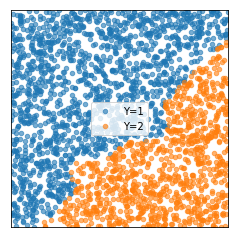

Creating 1 tasks...
BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)
[BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)]
[Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train), Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid), Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)]
No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (expert:slice_1:pred): Dat

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Full model saved at /Users/vincentchen/code/metal/logs/2019_05_13/21_10_12/model.pkl
{'expert:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529, 'expert:slice_1:pred/payload_test/labelset:slice_1:pred/f1': 0.9230769230769231, 'expert:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9174208144796381, 'expert:slice_1:pred/payload_train/labelset:slice_1:pred/accuracy': 0.8441558441558441, 'expert:slice_1:pred/payload_train/labelset:slice_1:pred/f1': 0.8378378378378377, 'expert:slice_1:pred/payload_train/labelset:slice_1:pred/acc_f1': 0.8409968409968409}
Creating 1 tasks...
BinaryClassificationTask(name=expert:slice_2:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:slice_2:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:slice_2:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:slice_2:p

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Full model saved at /Users/vincentchen/code/metal/logs/2019_05_13/21_10_25/model.pkl
{'expert:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375, 'expert:slice_2:pred/payload_test/labelset:slice_2:pred/f1': 0.8275862068965518, 'expert:slice_2:pred/payload_test/labelset:slice_2:pred/acc_f1': 0.8356681034482759, 'expert:slice_2:pred/payload_train/labelset:slice_2:pred/accuracy': 0.9512195121951219, 'expert:slice_2:pred/payload_train/labelset:slice_2:pred/f1': 0.96, 'expert:slice_2:pred/payload_train/labelset:slice_2:pred/acc_f1': 0.9556097560975609}
Creating 1 tasks...
BinaryClassificationTask(name=expert:BASE:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:BASE:pred': 'expert:BASE:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:BASE:pred': 'expert:BASE:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:BASE:pred': 'expert:BASE:pred'}], split=test)
[Bi

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'expert:BASE:pred/payload_test/labelset:BASE:pred/acc_f1': 0.968039686684073,
 'expert:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9648,
 'expert:BASE:pred/payload_test/labelset:BASE:pred/f1': 0.9712793733681462,
 'expert:BASE:pred/payload_train/labelset:BASE:pred/acc_f1': 0.9709366427171783,
 'expert:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.968,
 'expert:BASE:pred/payload_train/labelset:BASE:pred/f1': 0.9738732854343566}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_13/21_10_36/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_13/21_10_36/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_13/21_10_36/model.pkl
{'expert:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9648, 'expert:BASE:pred/payload_test/labelset:BASE:pred/f1': 0.9712793733681462, 'expert:BASE:pred/payload_test/labelset:BASE:pred/acc_f1': 0.968039686684073, 'expert:BASE:pred/payload_train/labelset:BASE:pred/a

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/acc_f1': 0.9855064935064934,
 'test_task/payload_test/labelset_gold/accuracy': 0.984,
 'test_task/payload_test/labelset_gold/f1': 0.987012987012987,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9869634241245135,
 'test_task/payload_train/labelset_gold/accuracy': 0.9856,
 'test_task/payload_train/labelset_gold/f1': 0.9883268482490272}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_13/21_10_56/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_13/21_10_56/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_13/21_10_56/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.984, 'test_task/payload_test/labelset_gold/f1': 0.987012987012987, 'test_task/payload_test/labelset_gold/acc_f1': 0.9855064935064934, 'test_task/payload_train/labelset_gold/accuracy': 0.9856, 'test_task/payload_train/labelset_gold/f1': 0.9883268482490272, 'test_task/payload_train/labelset_gold/

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


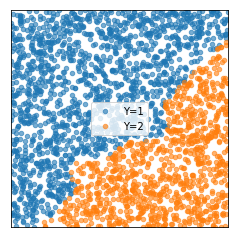

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (attention_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (head_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=5, out_features=1, bias=True)
      )
    )
  )
)

Total number of parameters: 21
Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /U

[135.0 epo]: test_task:[payload_train/labelset_gold/loss=8.47e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] model:[train/all/loss=8.47e-02, train/all/lr=1.00e-02, valid/all/loss=8.42e-02]
[140.0 epo]: test_task:[payload_train/labelset_gold/loss=8.47e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] model:[train/all/loss=8.47e-02, train/all/lr=1.00e-02, valid/all/loss=8.42e-02]
[145.0 epo]: test_task:[payload_train/labelset_gold/loss=8.47e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] model:[train/all/loss=8.47e-02, train/all/lr=1.00e-02, valid/all/loss=8.42e-02]
[150.0 epo]: test_task:[payload_train/labelset_gold/loss=8.47e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, paylo

[285.0 epo]: test_task:[payload_train/labelset_gold/loss=8.20e-02, payload_valid/labelset_gold/accuracy=9.73e-01, payload_valid/labelset_gold/f1=9.77e-01, payload_valid/labelset_gold/acc_f1=9.75e-01] model:[train/all/loss=8.20e-02, train/all/lr=1.00e-02, valid/all/loss=8.12e-02]
[290.0 epo]: test_task:[payload_train/labelset_gold/loss=8.19e-02, payload_valid/labelset_gold/accuracy=9.73e-01, payload_valid/labelset_gold/f1=9.77e-01, payload_valid/labelset_gold/acc_f1=9.75e-01] model:[train/all/loss=8.19e-02, train/all/lr=1.00e-02, valid/all/loss=8.08e-02]
[295.0 epo]: test_task:[payload_train/labelset_gold/loss=8.19e-02, payload_valid/labelset_gold/accuracy=9.73e-01, payload_valid/labelset_gold/f1=9.77e-01, payload_valid/labelset_gold/acc_f1=9.75e-01] model:[train/all/loss=8.19e-02, train/all/lr=1.00e-02, valid/all/loss=8.15e-02]
[300.0 epo]: test_task:[payload_train/labelset_gold/loss=8.18e-02, payload_valid/labelset_gold/accuracy=9.73e-01, payload_valid/labelset_gold/f1=9.77e-01, paylo

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/acc_f1': 0.9701749836280288,
 'test_task/payload_test/labelset_gold/accuracy': 0.9672,
 'test_task/payload_test/labelset_gold/f1': 0.9731499672560576,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9738121807465618,
 'test_task/payload_train/labelset_gold/accuracy': 0.9712,
 'test_task/payload_train/labelset_gold/f1': 0.9764243614931238}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_13/21_11_24/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_13/21_11_24/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_13/21_11_24/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9672, 'test_task/payload_test/labelset_gold/f1': 0.9731499672560576, 'test_task/payload_test/labelset_gold/acc_f1': 0.9701749836280288, 'test_task/payload_train/labelset_gold/accuracy': 0.9712, 'test_task/payload_train/labelset_gold/f1': 0.9764243614931238, 'test_task/payload_train/labelset_g

In [12]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
    create_preds = config.get("create_preds", True)
    custom_neck_dim = config.get("custom_neck_dim", None)
    h_dim = config.get("h_dim", None)
          
    tasks = create_tasks(
        task_name, 
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        create_preds=create_preds,
        custom_neck_dim=custom_neck_dim,
        h_dim=h_dim,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys,
        batch_size=16, 
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        create_preds=create_preds,
        verbose=True
    )
    visualize_payload(payloads[0])
          
    if model_name == 'moe':
        # train for same total num epochs
        expert_train_kwargs = copy.deepcopy(train_kwargs)
        expert_train_kwargs['n_epochs'] = int(train_kwargs['n_epochs'] / (len(all_slice_funcs) + 1))
        experts = train_slice_experts(
            uid_lists, Xs, Ys, MetalModel, all_slice_funcs, **expert_train_kwargs
        )
        model = model_class(tasks, experts, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **expert_train_kwargs)
    else:
        model = model_class(tasks, h_dim=h_dim, verbose=True, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task:remainder:pred).
labelset 'labelset:remainder:ind' -> task 'None' (originally, test_task:remainder:ind).
==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9174208144796381,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task:slice_1:pred/payload_test/labelset:sli

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


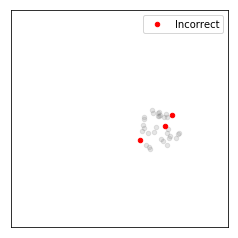

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


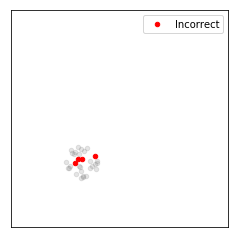

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9174208144796381,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/f1': 0.9230769230769231,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/acc_f1': 0.8412298387096775,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/f1': 0.8387096774193549}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


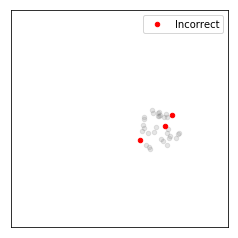

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


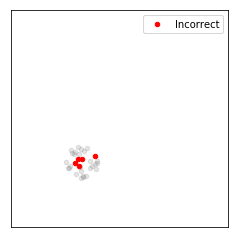

In [13]:
for model_name in model_configs.keys():
    if model_name == 'soft_param':
        labelcats_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",    
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind",
        }
    else:
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",        
        }

    eval_payload.remap_labelsets(labels_to_tasks, default_none=True)
    if model_name in ["hard_param", "soft_param", "manual_reweighting"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
labelset 'labelset:remainder:pred' -> task 'test_task' (originally, None).
==========Evaluating soft_param_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9885669681408125,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.987331081081081,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9898028552005439,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.9455882352941176,
    'test_task/pa

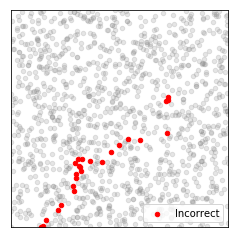

Vizualizing test_task predictions on labelset:slice_1:pred


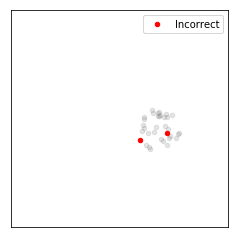

Vizualizing test_task predictions on labelset:slice_2:pred


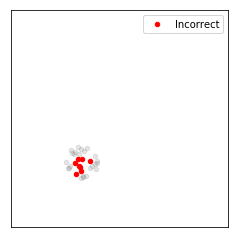

Vizualizing test_task predictions on labelset:remainder:pred


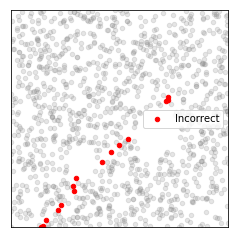

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.990845238971942,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9898648648648649,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9918256130790191,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.40106951871657753,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_1:pred/f1': 0.2727272727272727,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.5454861111111111,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.46875,
    'test_task/payload_test/labelset:

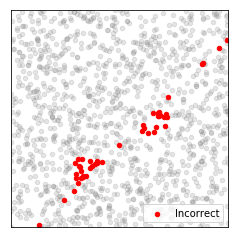

Vizualizing test_task predictions on labelset:slice_1:pred


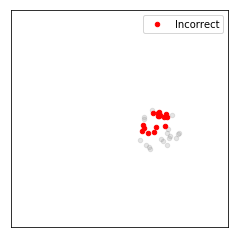

Vizualizing test_task predictions on labelset:slice_2:pred


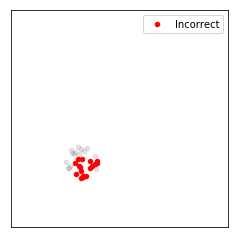

Vizualizing test_task predictions on labelset:remainder:pred


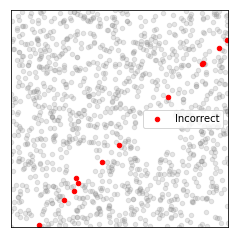

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9916055818088028,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9907094594594594,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.992501704158146,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.40106951871657753,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_1:pred/f1': 0.2727272727272727,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.5454861111111111,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.46875,
    'test_task/payload_test/l

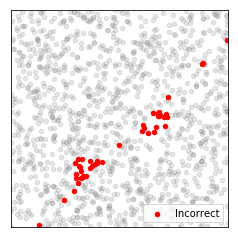

Vizualizing test_task predictions on labelset:slice_1:pred


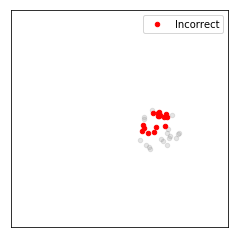

Vizualizing test_task predictions on labelset:slice_2:pred


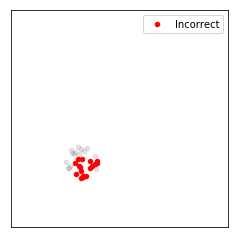

Vizualizing test_task predictions on labelset:remainder:pred


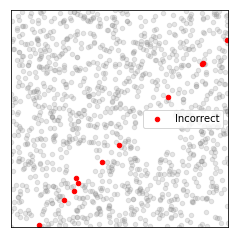

==========Evaluating moe==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9893324030552291,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9881756756756757,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9904891304347826,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.915341812400636,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task/payload_test/labelset:slice_1:pred/f1': 0.918918918918919,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.9047379032258065,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.90625,
    'test_task/payload_test/labelset:slice_2:p

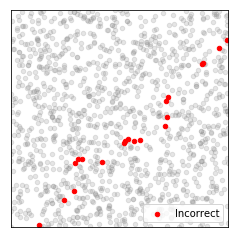

Vizualizing test_task predictions on labelset:slice_1:pred


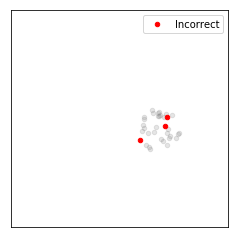

Vizualizing test_task predictions on labelset:slice_2:pred


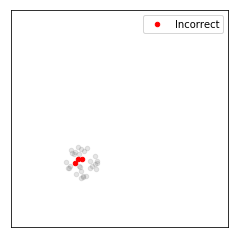

Vizualizing test_task predictions on labelset:remainder:pred


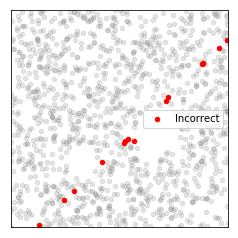

==========Evaluating naive==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9931192421888008,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9923986486486487,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9938398357289528,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.40106951871657753,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_1:pred/f1': 0.2727272727272727,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.5681818181818181,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.5,
    'test_task/payload_test/labelset:slice_2:

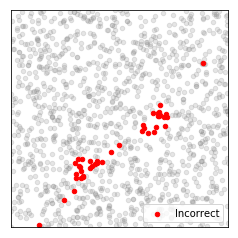

Vizualizing test_task predictions on labelset:slice_1:pred


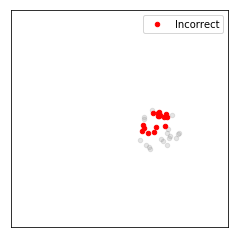

Vizualizing test_task predictions on labelset:slice_2:pred


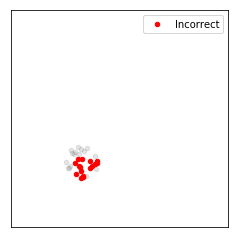

Vizualizing test_task predictions on labelset:remainder:pred


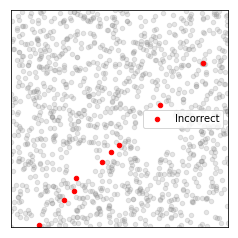

In [14]:
# map all labelsets to the primary task_head 
eval_payload.remap_labelsets(labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task",
        "labelset:remainder:pred": "test_task",
    }, default_none=True
                            
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

********** soft_param_rep **********
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
Vizualizing test_task:BASE:ind attention on labelset_gold


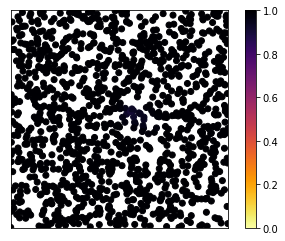

Vizualizing test_task:slice_1:ind attention on labelset_gold


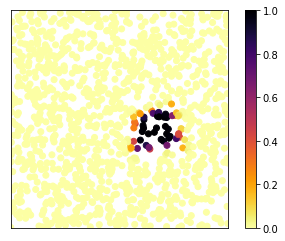

Vizualizing test_task:slice_2:ind attention on labelset_gold


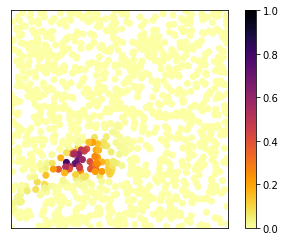

Vizualizing test_task:BASE:ind attention on labelset:slice_1:pred


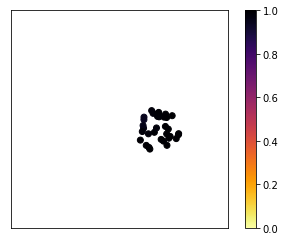

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:pred


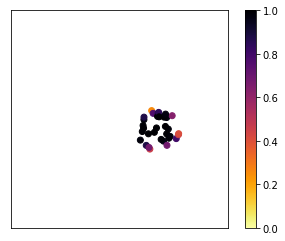

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:pred


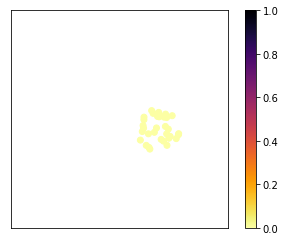

Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


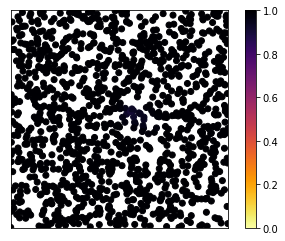

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


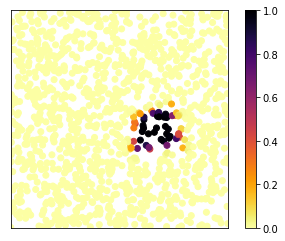

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


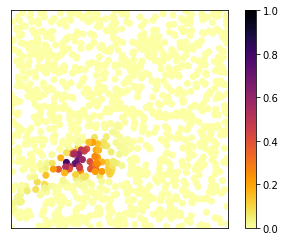

Vizualizing test_task:BASE:ind attention on labelset:slice_2:pred


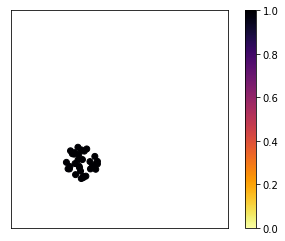

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:pred


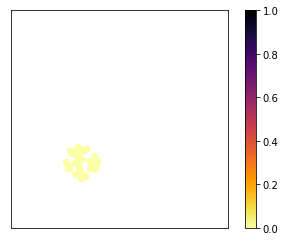

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:pred


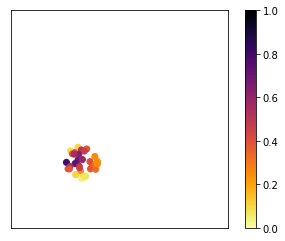

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


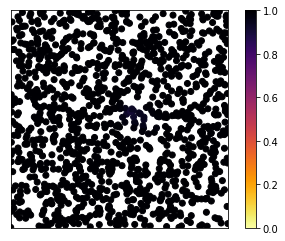

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


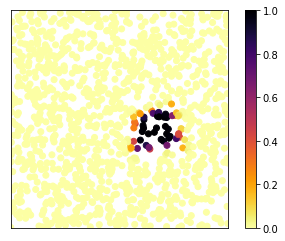

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


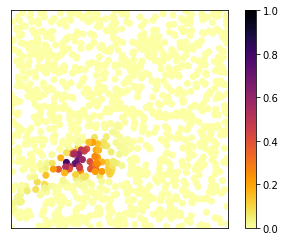

Vizualizing test_task:BASE:ind attention on labelset:remainder:pred


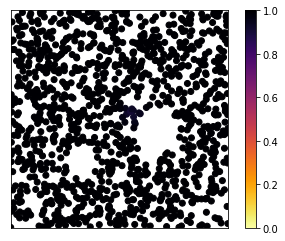

Vizualizing test_task:slice_1:ind attention on labelset:remainder:pred


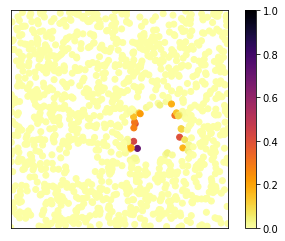

Vizualizing test_task:slice_2:ind attention on labelset:remainder:pred


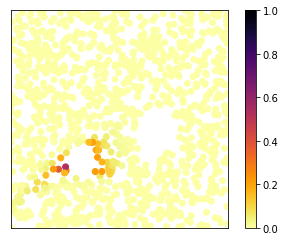

In [15]:
for model_name in trained_models.keys():
    if model_name not in ['soft_param', 'soft_param_rep']:
        continue

    print(f'{"*"*10} {model_name} {"*"*10}')
    eval_payload.remap_labelsets(labels_to_tasks = {
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind"
        }
    )

    visualize_attention(trained_models[model_name], eval_payload)